<!-- # pip install -U jedi==0.17.2 -->

# SageMaker Hosting を利用して TensorFlow のモデルを SageMaker hosting のいろいろな機能を使ってホスティングする
* ホスティングするモデルは pretrained モデルである MobileNet (とv2)を題材にする
* SageMaker Studio の以下環境の使用を前提とする
  * `TensorFlow 2.3 Python 3.7 CPU Optimized`
  * `t3.medium` または `m5.large`
* 以下コンテンツの 1 と 2 は実行必須だが、あとは実行したいところから実行可能

## contents
* [1. (必須)使用するモジュールのインストールと読み込み、定数の設定](#1.-(必須)使用するモジュールのインストールと読み込み、定数の設定)
* [2. (必須)使用するモデルの動作確認と-S3-への転送](#2.-(必須)使用するモデルの動作確認と-S3-への転送)
* [3. TensorFlow の SageMaker マネージドコンテナ(TensorFlow Serving)を利用した hosting](#3.-TensorFlow-の-SageMaker-マネージドコンテナ(TensorFlow-Serving)を利用した-hosting)
  * [#3-1. SageMaker SDK の場合の手順概要](#3-1.-SageMaker-SDK-の場合の手順概要)
  * [#3-2. boto3 の場合の手順概要](#3-2.-boto3-の場合の手順概要)
* [4. 前処理/後処理追加](#4.-前処理/後処理追加)
  * [4-1. SageMaker Python SDK で前処理/後処理を追加してホスティングと推論](#4-1.-SageMaker-Python-SDK-で前処理/後処理を追加してホスティングと推論)
  * [4-2. Boto3 で前処理/後処理を追加してホスティングと推論](#4-2.-Boto3-で前処理/後処理を追加してホスティングと推論)
* [5. マルチモデルエンドポイント](#5.-マルチモデルエンドポイント)
* [6. 非同期推論](#6.-非同期推論)
* [7. オートスケール](#7.-オートスケール)
* [8. サーバーレス推論](#8.-サーバーレス推論)
* [9. 独自コンテナイメージの持ち込みを利用した推論](#9.-独自コンテナイメージの持ち込みを利用した推論)

## 1. (必須)使用するモジュールのインストールと読み込み、定数の設定

In [ ]:
pip install -U matplotlib sagemaker

In [1]:
import tensorflow as tf, os, tarfile, json, numpy as np, base64, sagemaker, boto3
from sagemaker.tensorflow import TensorFlowModel
from io import BytesIO
from matplotlib import pyplot as plt
from PIL import Image
from time import sleep
from glob import glob
sm_client = boto3.client('sagemaker')
smr_client = boto3.client('sagemaker-runtime')
s3_client = boto3.client('s3')
endpoint_inservice_waiter = sm_client.get_waiter('endpoint_in_service')
sm_role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
bucket = sess.default_bucket()
print(f'使用するロール : {sm_role}')
print(f'使用するバケット : {bucket}')

使用するロール : arn:aws:iam::290000338583:role/service-role/AmazonSageMaker-ExecutionRole-20211201T141392
使用するバケット : sagemaker-us-east-2-290000338583


## 2. (必須)使用するモデルの動作確認と S3 への転送
1. tensorflow の pre-trained model である mobilenet を読み込む
2. 推論用の画像とラベルをダウンロード
3. 推論用の画像を前処理
4. モデルを tar.gz に固めて S3 にアップロード(SageMaker Hosting するため)
5. 使用する推論用コンテナの URI を取得

In [2]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

[2021-12-23 12:35:06.175 tensorflow-2-3-cpu-py3-ml-m5-large-8521a5fb9ffffd39d688baebdae4:341 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-23 12:35:06.317 tensorflow-2-3-cpu-py3-ml-m5-large-8521a5fb9ffffd39d688baebdae4:341 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_____________

In [3]:
WORK_DIR = f'{os.getcwd()}/work/'

os.makedirs(WORK_DIR, exist_ok=True)
# サンプル画像をダウンロード
file = tf.keras.utils.get_file(
    f'{WORK_DIR}cat.jpg',
    'https://gahag.net/img/201608/11s/gahag-0115329292-1.jpg')

# 分類クラスをダウンロード
labels_path = tf.keras.utils.get_file(
    f'{WORK_DIR}/ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = list(np.array(open(labels_path).read().splitlines())[1:])

In [4]:
with open('./code/labels.txt','wt') as f:
    for txt in labels:
        f.write(txt+'\n')

In [5]:
imsize = Image.open(file).size

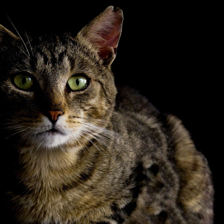

In [6]:
# 画像のresizeと前処理結果の確認
x,y = imsize[0]-imsize[1],0
img = Image.open(file).crop((x,y,900,537)).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)
img

In [7]:
# モデルの動作確認
print(labels[np.argmax(model.predict(img_arr))]) # tabby

tabby


In [8]:
# 保存ディレクトリを指定
MODEL_DIR = './mobilenet/0001'

# tar.gz の出力先を指定
TAR_DIR = 'MyModel'
os.makedirs(TAR_DIR, exist_ok=True)
TAR_NAME = os.path.join(TAR_DIR, 'model.tar.gz')

# モデルを SavedModel 形式で保存
model.save(MODEL_DIR)

# tar.gz ファイルを出力
with tarfile.open(TAR_NAME, mode='w:gz') as tar:
    tar.add(MODEL_DIR)

# S3 にアップロードして、返り値としてS3のURIを受け取る
model_s3_path = f's3://{bucket}/{TAR_DIR}'

model_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = TAR_NAME,
    desired_s3_uri = model_s3_path
)

print(model_s3_uri)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


s3://sagemaker-us-east-2-290000338583/MyModel/model.tar.gz


In [9]:
# Sagemaker SDK でマネージドコンテナの URI を取得
container_image_tf24_uri = sagemaker.image_uris.retrieve(
    "tensorflow",  # TensorFlow のマネージドコンテナを利用
    sagemaker.session.Session().boto_region_name, # ECR のリージョンを指定
    version='2.4', # TensorFlow のバージョンを指定
    instance_type = 'ml.m5.large', # インスタンスタイプを指定
    image_scope = 'inference' # 推論コンテナを指定
)

print(container_image_tf24_uri)


763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-inference:2.4-cpu


## 3. TensorFlow の SageMaker マネージドコンテナ(TensorFlow Serving)を利用した hosting
* コンテナの詳細は[こちら](https://github.com/aws/sagemaker-tensorflow-serving-container)
* SageMaker SDK と boto3 を利用した場合それぞれ行う
* 前提として事前に saved model 形式で保存したモデルを tar.gz に固めて S3 に配置しておく(2 で実施済)

### 3-1. SageMaker SDK の場合の手順概要
1. SavedModel 形式でモデルを保存(済)
2. モデルを tar.gz で固める(済)
3. S3 にモデルをアップロード(済)
4. SageMaker SDK の [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html?highlight=TensorFlowModel#sagemaker.tensorflow.model.TensorFlowModel) API で S3 に配置したモデルを読み込む
5. [deploy](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html?highlight=TensorFlowModel#sagemaker.tensorflow.model.TensorFlowModel.deploy) メソッドで推論エンドポイントを作成
6. 推論実行
7. 推論エンドポイントを削除（付随するものも合わせて削除）

In [10]:
MODEL_NAME = 'MyTFModelFromSMSDK'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'Endpoint'
ENDPOINT_NAME = ENDPOINT_CONFIG_NAME

In [11]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = MODEL_NAME,
    model_data=model_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_tf24_uri, # コンテナイメージの S3 URI
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=ENDPOINT_NAME, # エンドポイントの名前
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.large', # インスタンスタイプ
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: MyTFModelFromSMSDK
INFO:sagemaker:Creating endpoint with name MyTFModelFromSMSDKEndpoint


----!

In [12]:
img = Image.open(file).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)

In [13]:
result = np.argmax(predictor.predict(img_arr)['predictions'][0])
print(labels[result])

tabby


In [14]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

### 3-2. boto3 の場合の手順概要
1. SavedModel 形式でモデルを保存(済)
2. モデルを tar.gz で固める(済)
3. S3 にモデルをアップロード(済)
4. boto3 の [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) メソッドで SageMaker のサービスに S3 にアップロードしたモデルを登録する
5. boto3 の [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config)で推論エンドポイントの設定を作成する
6. boto3 の [create_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint) で推論エンドポイントを作成する
7. boto3 の [invoke_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html#SageMakerRuntime.Client.invoke_endpoint) で推論する
8. 推論エンドポイントを削除

In [15]:
MODEL_NAME = 'MyTFModelAddProcessFromBoto3'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'

In [16]:
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)


In [17]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)


In [18]:
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)
endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

In [19]:
# リストを文字列にして渡すパターン
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : str(img_arr.tolist())
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.601579428


In [20]:
# jsonにして渡すパターン
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.601579428


In [21]:
# リソース削除
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 4. 前処理/後処理追加
* リスト形式でデータを作成し(た後で json形式に変換し)て predict を行っていたが、 `inference.py` を使うことで前処理/後処理を endpoint 側で行うことも可能。
  * 重い画像の前処理を潤沢なエンドポイントのコンピューティングリソースで実行することで、呼び出し側　(Lambda など)の頻繁に処理するコンピューティングリソースの負荷を低減できる
  * 呼び出し側が前処理を意識せずに実装できるようになる(呼び出し側はデータサイエンティストの領域に入らずに済み、エンドポイントで実行する前処理までをDSの領域にできる）
* 以下を例に実装する。  
    * 前処理）画像のバイナリデータを base64 エンコーディングしたものを直接送りつけて、 endpoint 側でリストに変換
    * 後処理）softmax の結果から一番可能性の高い値を取得し、そのインデックスからラベルに変換

### 4-1. SageMaker Python SDK で前処理/後処理を追加してホスティングと推論
手順は前後の処理無しの場合と同じで、`TensorFlowModel` APIでモデルを読み込む際、前処理/後処理を記載した `inference.py` とそのディレクトリを指定する

In [22]:
!pygmentize ./code/inference.py

import json, numpy as np, tensorflow as tf, base64, os
from pathlib import Path

INPUT_SIZE=(224,224)

with open('/opt/ml/model/code/labels.txt','rt') as f:
    label = f.read().split('\n')[0:-1]

def input_handler(data, context):
    b64_data = json.loads(data.read().decode("utf-8"))['b64_image']
    raw_tensor = tf.io.decode_jpeg(base64.b64decode(b64_data.encode('utf-8')))
    normalization_list = ((tf.image.resize(raw_tensor,(INPUT_SIZE[0],INPUT_SIZE[1])).numpy()-127.5)/127.5).reshape(-1,INPUT_SIZE[0],INPUT_SIZE[1],3).tolist()
    return json.dumps({"instances":normalization_list})
    
def output_handler(data, context):
    response_content_type = context.accept_header
    prediction = label[np.argmax(json.loads(data.content.decode('utf-8'))['predictions'][0])]
    return prediction, response_content_type


In [23]:
MODEL_NAME = 'MyTFModelAddProcessFromSMSDK'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'Endpoint'
ENDPOINT_NAME = ENDPOINT_CONFIG_NAME

In [24]:
TAR_DIR = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(TAR_DIR, exist_ok=True)
TAR_NAME = os.path.join(TAR_DIR, 'model.tar.gz')
with tarfile.open(TAR_NAME, mode='w:gz') as tar:
    tar.add(MODEL_DIR)

In [25]:
model_add_process_s3_path = f's3://{bucket}/{TAR_DIR}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = TAR_NAME,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

s3://sagemaker-us-east-2-290000338583/MyModelAddProcess/model.tar.gz


#### inference.py と必要なファイルの設定
* entry_point 引数で `inference.py` (名前固定)を指定すると `input_handler` と `output_handler` を推論前後に実行してくれる
* 必要なモジュール等がある場合は `source_dir` 引数に格納してあるディレクトリを指定すると一緒に読み込むが、 inference.py が `source_dir` のルートに存在する必要がある
* ホスティング先の展開ディレクトリは `/opt/ml/model/code` になるので、他のファイルを読み込む時は絶対パスで指定するとよい（カレントディレクトリは `/sagemaker` で実行される）

In [26]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = MODEL_NAME,
    model_data=model_add_process_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_tf24_uri, # コンテナイメージの S3 URI
    entry_point = './code/inference.py',
    source_dir = './code/'
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=ENDPOINT_NAME,
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.xlarge', # インスタンスタイプ
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: MyTFModelAddProcessFromSMSDK
INFO:sagemaker:Creating endpoint with name MyTFModelAddProcessFromSMSDKEndpoint


-----!

In [27]:
# 推論
with open('./work/cat.jpg', 'rb') as img:
    data = img.read()
bio = BytesIO()
bio.write(data)
b64_data = base64.b64encode(bio.getvalue()).decode('utf-8')
json_b64 = json.dumps({'b64_image':b64_data})
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

tabby


In [28]:
# おかたづけ
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

### 4-2. Boto3 で前処理/後処理を追加してホスティングと推論

In [29]:
MODEL_NAME = 'MyTFModelAddProcessFromBoto3'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'

#### inference.py 他を model.tar.gz に同包 
boto3 から endpoint を作成する場合は、SageMaker SDK のように `entry_point` や `source_dir` の設定ができないため、 必要なファイルは予め `model.tar.gz` に一緒に入れる必要がある  
(SageMaker SDK の場合は裏側で自動で `inference.py` などを model.tar.gz に再度固めて s3 にアップロードしてくれている)

In [30]:
# model.tar.gz にモデルなどを固める
TAR_DIR = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(TAR_DIR, exist_ok=True)
TAR_NAME = os.path.join(TAR_DIR, 'model.tar.gz')
with tarfile.open(TAR_NAME, mode='w:gz') as tar:
    tar.add(MODEL_DIR)
    tar.add(code_dir) # inference.py などを同包

In [31]:
model_add_process_s3_path = f's3://{bucket}/{TAR_DIR}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = TAR_NAME,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

s3://sagemaker-us-east-2-290000338583/MyModelAddProcess/model.tar.gz


In [32]:
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_add_process_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)

endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

In [33]:
# 推論
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

tabby


In [34]:
# 削除
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 5. マルチモデルエンドポイント
* １つの推論インスタンスに複数のモデルをデプロイすることが可能
* モデルごとにtar.gzにかためて、S3 の指定プレフィックス直下に配置する
* 以下は boto3 の例。SageMaker SDK でもマルチモデルエンドポイントは可能で詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html?highlight=multi%20model#deploying-more-than-one-model-to-your-endpoint)
* エンドポイント作成手順はシングルモデルと変わらないが、それぞれのモデルを {モデル名}.tar.gz に固めた上で同じキープレフィックスに配置し、create_model する際の引数に、tar.gzを配置しているプレフィックス(tar.gzのオブジェクトのURIではない）を指定する
* 呼び出す(invoke_endpoint)する際にモデルのファイル名を指定する


### モデル準備と動作確認( mobilenetv2 )
新しくmobilenetv2を追加し、mobilenetとmobilenetv2の2モデルを１つのエンドポイントでホスティングする準備

In [35]:
model2 = tf.keras.applications.mobilenet_v2.MobileNetV2()
model2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [36]:
# モデルの動作確認(v1との比較)
# mobilenet
prediction = model.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])
# mobilenetV2
prediction = model2.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])

0.6015794 tabby
0.39508948 tabby


In [37]:
# MobileNetV2 の準備
# 保存ディレクトリを指定
MODEL2_DIR = './mobilenetv2/0001'

# モデルを SavedModel 形式で保存
model2.save(MODEL2_DIR)

# mobilenetv2.tar.gz の出力先を指定
TAR_DIR = 'MyMultiModel'
os.makedirs(TAR_DIR, exist_ok=True)
TAR_NAME = os.path.join(TAR_DIR, 'mobilenetv2.tar.gz')

# tar.gz ファイルを出力
with tarfile.open(TAR_NAME, mode='w:gz') as tar:
    tar.add(MODEL2_DIR, arcname="0001")

# MobileNet の準備
# mobilenet.tar.gz の出力先を指定
TAR_NAME = os.path.join(TAR_DIR, 'mobilenet.tar.gz')
# tar.gz ファイルを出力
with tarfile.open(TAR_NAME, mode='w:gz') as tar:
    tar.add(MODEL_DIR, arcname="0001")

INFO:tensorflow:Assets written to: ./mobilenetv2/0001/assets


INFO:tensorflow:Assets written to: ./mobilenetv2/0001/assets


In [38]:
# mobilenet と mobilenet v2 をそれぞれ S3 にアップロードする
multi_model_s3_path = f's3://{bucket}/{TAR_DIR}/'

!aws s3 cp ./{TAR_DIR}/ {multi_model_s3_path} --recursive

upload: MyMultiModel/mobilenet.tar.gz to s3://sagemaker-us-east-2-290000338583/MyMultiModel/mobilenet.tar.gz
upload: MyMultiModel/mobilenetv2.tar.gz to s3://sagemaker-us-east-2-290000338583/MyMultiModel/mobilenetv2.tar.gz


In [39]:
MODEL_NAME = 'MyMultiModel'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'

### モデルの作成～エンドポイント作成
* シングルモデルのときはtar.gzのパスを指定していたが、マルチモデルのときはモデルを保存しているプレフィックスを指定する
* 他はシングルモデルと同じ

In [40]:
response = sm_client.create_model(
    ModelName=MODEL_NAME,
        PrimaryContainer={
        'Image': container_image_tf24_uri,
        'Mode':'MultiModel',
        'ModelDataUrl': multi_model_s3_path, # tar.gz を複数配置している s3 のプレフィックスを指定
    },
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)

endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

### マルチモデルエンドポイントでの推論
* `TargetModel` 引数にtar.gzに固めたモデルのファイル名を入れればそのモデルが使用される

In [41]:
# mobilenet推論
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenet.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.601579428


In [42]:
# mobilenetv2推論
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenetv2.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.395089477


### モデルの追加
* 同じプレフィックス下に新しくモデルを追加すれば追加したモデルで推論可能
* ここでは mobilenetv2 を別名に差し替えて(mobilenetv2**_2**)、追加でアップロードしてそちらも機能することを確認する

注１）モデルの削除は S3 から削除すればできるが、タイムラグがかなりあるので注意。モデルをホスティングをしているインスタンスからモデルが削除されない限り（コントロールできない領域で、ホスティングしているインスタンスのメモリ/ストレージが不足したときのみ自動で読み込んでいるモデルが削除される）S3から削除したモデルで推論できる。  
注２）同様にモデルの更新についても、S3に配置したモデルを上書き保存しても古いモデルがうごき続けてしまう可能性がある。[公式のメッセージ](https://docs.aws.amazon.com/sagemaker/latest/dg/add-models-to-endpoint.html)としては「上書き保存はするな」

In [43]:
!aws s3 cp ./{TAR_DIR}/mobilenetv2.tar.gz {multi_model_s3_path}mobilenetv2_2.tar.gz

upload: MyMultiModel/mobilenetv2.tar.gz to s3://sagemaker-us-east-2-290000338583/MyMultiModel/mobilenetv2_2.tar.gz


In [44]:
# mobilenet推論
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenetv2_2.tar.gz', # 後から追加したモデル
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.395089477


In [45]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 6. 非同期推論
* 非同期推論は、推論リクエストがないときにインスタンス数を 0 にすることコストを削減する
* バッチ変換(batch transform)と近いが、バッチ変換はデータが溜まっている前提で一気に動かすのに対して、個別のデータに対して数分オーダで推論結果を求められる場合に適する（非同期推論は推論対象データが数 GB でも返せる）
* 詳細は[こちら](https://aws.amazon.com/jp/about-aws/whats-new/2021/08/amazon-sagemaker-asynchronous-new-inference-option/)
* 使い方はリアルタイム推論に近いが、`endpoint_config`で非同期独自の設定をする

In [46]:
MODEL_NAME = 'MyTFModelFromBoto3Async'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'

### モデルの作成
リアルタイム推論と同じ

In [47]:
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)

### 推論エンドポイントの設定
`AsyncInferenceConfig` という引数で、推論結果を配置するS3の出力先を指定する

In [48]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/async_inference/output"
        },
    }
)


### 推論エンドポイントの作成
リアルタイム推論と同じ

In [49]:
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)

endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

### 非同期推論実行
事前にS3に推論データを配置して、`invoke_endpoint_async`で非同期推論を実行する

In [50]:
json_name = './tabby.json' 
with open(json_name,'wt') as f:
    f.write(json.dumps({"instances": img_arr.tolist()}))
tabby_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = json_name,
    desired_s3_uri = f"s3://{bucket}/async_inference/input"
)

In [51]:
%%time
response = smr_client.invoke_endpoint_async(
    EndpointName=ENDPOINT_NAME, 
    InputLocation=tabby_s3_uri,
    ContentType='application/json'
)
output_s3_uri = response['OutputLocation']
output_key = output_s3_uri.replace(f's3://{bucket}/','')
while True:
    result = s3_client.list_objects(Bucket=bucket, Prefix=output_key)
    exists = True if "Contents" in result else False
    if exists:
        print('!')
        obj = s3_client.get_object(Bucket=bucket, Key=output_key)
        predictions = json.loads(obj['Body'].read().decode())['predictions'][0]
        print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])
        break
    else:
        print('.',end='')
        sleep(0.1)

............!
tabby 0.601579428
CPU times: user 61.1 ms, sys: 3.89 ms, total: 65 ms
Wall time: 1.59 s


In [52]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 7. オートスケール
* Endpoint はオートスケールさせることができる
  * 推論が増えたら自動で増強、減ったら削減、など
  * スケーリング対象のメトリクスは[こちら](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html#cloudwatch-metrics-endpoint-invocation)
* 以下は非同期推論を用いてオートスケールをした場合だが、同期推論もやり方は同じ
* オートスケールはエンドポイントを立てた後、 AWS の アプリケーションオートスケーリングサービスを利用して実現する

In [53]:
MODEL_NAME = 'MyTFModelFromBoto3AsyncWithAutoScaling'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'

### モデルの作成

In [54]:
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        'Image': container_image_tf24_uri,
        'ModelDataUrl': model_s3_uri,
    },
    ExecutionRoleArn=sm_role,
)

### 推論エンドポイントの設定

In [55]:
VARIANT_NAME = 'MyVariant'
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': VARIANT_NAME,
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/async_inference_with_autoscaling/output"
        },
    }
)


In [56]:
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)

endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

In [57]:
# オートスケーリングの設定
aa_client = boto3.client('application-autoscaling')
SCALABLE_DIMENSION = 'sagemaker:variant:DesiredInstanceCount'

resource_id = (f'endpoint/{ENDPOINT_NAME}/variant/{VARIANT_NAME}')

response = aa_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension=SCALABLE_DIMENSION,
    MinCapacity=1,
    MaxCapacity=2,
)

response = aa_client.put_scaling_policy(
    PolicyName="Invocations-ScalingPolicy",
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension=SCALABLE_DIMENSION,
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 1.0,
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": ENDPOINT_NAME}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 10,
        "ScaleOutCooldown": 10
    },
)

In [58]:
# インスタンス数の確認
instance_count=sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)['ProductionVariants'][0]['CurrentInstanceCount']
print(f'現在稼動しているインスタンス数: {instance_count}')

現在稼動しているインスタンス数: 1


### 推論を50000回行って負荷をかけてオートスケーリングするかを確認する

In [59]:
%%time

json_name = './tabby.json' 
with open(json_name,'wt') as f:
    f.write(json.dumps({"instances": img_arr.tolist()}))
tabby_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = json_name,
    desired_s3_uri = f"s3://{bucket}/async_inference/input"
)

output_key_list = []
# 推論
for _ in range(50000):
    response = smr_client.invoke_endpoint_async(
        EndpointName=ENDPOINT_NAME, 
        InputLocation=tabby_s3_uri,
        ContentType='application/json'
    )
    output_s3_uri = response['OutputLocation']
    output_key = output_s3_uri.replace(f's3://{bucket}/','')
    output_key_list.append(output_key)

# 全ての結果を確認する
for output_key in output_key_list:
    while True:
        result = s3_client.list_objects(Bucket=bucket, Prefix=output_key)
        exists = True if "Contents" in result else False
        if exists:
#             print('!',end='')
#             # 結果確認
#             obj = s3_client.get_object(Bucket=bucket, Key=output_key)
#             predictions = json.loads(obj['Body'].read().decode())['predictions'][0]
#             print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])
            break
        else:
            print('.',end='')
            sleep(1)

# インスタンス数の確認
instance_count=sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)['ProductionVariants'][0]['CurrentInstanceCount']
print(f'現在稼動しているインスタンス数: {instance_count}')

現在稼動しているインスタンス数: 2
CPU times: user 2min 53s, sys: 5.79 s, total: 2min 59s
Wall time: 28min 53s


In [60]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 8. サーバーレス推論(2021/12時点ではパブリックプレビュー)
* インスタンスを意識せずにエンドポイントだけ建てる
* 実態は推論イベント発生時に都度コンピューティングリソースが立ち上がる
* 通常のリアルタイム推論との違いは `create_endpoint_config` する際に、インスタンス数やインスタンスタイプの設定はしなくなり、代わりに`ServerlessConfig`の中でメモリと最大同時期同数を設定する

In [61]:
MODEL_NAME = 'MyTFModelFromBoto3Serverless'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        'Image': container_image_tf24_uri,
        'ModelDataUrl': model_s3_uri,
    },
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            # インスタンスカウントやインスタンスタイプはなくなる
            'ServerlessConfig': { # 通常のリアルタイム推論とは違い、ServerlessConfig というキーで設定する
                'MemorySizeInMB': 1024, # メモリサイズは 1024 , 2048, 3072, 4096, 5120, 6144 から選ぶ
                'MaxConcurrency': 3 # 最大同時起動数
            }
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)

endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

In [62]:
# jsonにして渡すパターン
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.601578653


In [63]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)

## 9. 独自コンテナイメージの持ち込みを利用した推論
* SageMaker のマネージドコンテナイメージ以外に、独自のコンテナイメージを持ち込める
* コンテナイメージをビルドし、ECR にプッシュしてその URL を指定する以外はマネージドコンテナイメージと使い方が一緒
* SageMaker Studio の場合はコンテナイメージのビルドに `sm-docker build` コマンドを使う必要がある
  * `sm-docker build` する前にロールの信頼関係とポリシーを追加する必要がある  
    `sm-docker build` が裏側で AWS CodeBuild を使うために必要
* SageMaker Notebook (classic) の場合はそのまま `docker build` コマンドを使えばよい

In [64]:
# 定数の設定
IMAGE_NAME = 'sagemaker_byoc_tf_inference-cpu'
TAG = ':1'

### ビルドするコンテナイメージと、依存関係のあるモジュールの確認

In [65]:
!cat container/Dockerfile

FROM tensorflow/tensorflow:2.5.2

RUN apt-get -y update && apt-get install -y --no-install-recommends \
         wget \
         python3-pip \
         python3-setuptools \
         nginx \
         ca-certificates \
    && rm -rf /var/lib/apt/lists/*
RUN ln -s /usr/bin/python3 /usr/bin/python
RUN ln -s /usr/bin/pip3 /usr/bin/pip
COPY requirements.txt ./ 
RUN pip --no-cache-dir install -r requirements.txt
ENV PYTHONUNBUFFERED=TRUE
ENV PYTHONDONTWRITEBYTECODE=TRUE
ENV PATH="/opt/program:${PATH}"
COPY tfserve /opt/program
WORKDIR /opt/program



In [66]:
!cat container/requirements.txt

cython
flask
gunicorn


### **SageMaker Studio を使っている場合のみ**以下を実行
#### sm-docker コマンドのインストール

In [67]:
!pip install sagemaker-studio-image-build

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


#### Studio アタッチされているロールに以下の信頼関係を追加
以下のコマンドの出力結果をコピーして追加する

In [68]:
!cat container/trust_relationships.json

{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "sagemaker.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "codebuild.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

#### Studio アタッチされているロールにインラインポリシー（もしくはポリシーを別途作成して）アタッチする
以下のコマンドの出力結果をコピーしてアタッチする

In [69]:
!cat container/inline_policy.json

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
   

#### コンテナイメージのビルド

In [70]:
%cd container
!chmod +x tfserve/serve
!sm-docker build . --repository {IMAGE_NAME}{TAG}
%cd ../

/root/aws-ml-jp/sagemaker/sagemaker-inference/tensorflow/container
...
[Container] 2021/12/23 13:25:29 Waiting for agent ping

[Container] 2021/12/23 13:25:30 Waiting for DOWNLOAD_SOURCE
[Container] 2021/12/23 13:25:32 Phase is DOWNLOAD_SOURCE
[Container] 2021/12/23 13:25:32 CODEBUILD_SRC_DIR=/codebuild/output/src375224830/src
[Container] 2021/12/23 13:25:32 YAML location is /codebuild/output/src375224830/src/buildspec.yml
[Container] 2021/12/23 13:25:32 Processing environment variables
[Container] 2021/12/23 13:25:32 No runtime version selected in buildspec.
[Container] 2021/12/23 13:25:32 Moving to directory /codebuild/output/src375224830/src
[Container] 2021/12/23 13:25:32 Configuring ssm agent with target id: codebuild:03571307-d4cc-4005-99e9-777b5552c786
[Container] 2021/12/23 13:25:32 Successfully updated ssm agent configuration
[Container] 2021/12/23 13:25:32 Registering with agent
[Container] 2021/12/23 13:25:32 Phases found in YAML: 3
[Container] 2021/12/23 13:25:32  BUILD: 4 

In [71]:
account_id = boto3.client('sts').get_caller_identity()['Account']
region_name = boto3.session.Session().region_name
tf_own_image_uri = f'{account_id}.dkr.ecr.{region_name}.amazonaws.com/{IMAGE_NAME}{TAG}'
print(tf_own_image_uri)

290000338583.dkr.ecr.us-east-2.amazonaws.com/sagemaker_byoc_tf_inference-cpu:1


### **SageMaker Notebook (classic) をつかってる場合のみ**以下を実行

In [ ]:
%cd container
!chmod +x tfserve/serve
!docker build -t {IMAGE_NAME}{TAG} .
%cd ../

In [ ]:
# boto3の機能を使ってリポジトリ名に必要な情報を取得する
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name
ecr_endpoint = f'{account_id}.dkr.ecr.{region}.amazonaws.com/' 
repository_uri = f'{ecr_endpoint}{IMAGE_NAME}'
tf_own_image_uri = f'{repository_uri}{TAG}'

!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {ecr_endpoint}
!docker tag {image_name}{tag} {image_uri}
# 同名のリポジトリがあった場合は削除
!aws ecr delete-repository --repository-name $image_name --force
# リポジトリを作成
!aws ecr create-repository --repository-name $image_name
# イメージをプッシュ
!docker push {image_uri}

### 以下共通で推論エンドポイントの作成

In [72]:
MODEL_NAME = 'MyTFModelFromBoto3BYOC'
ENDPOINT_CONFIG_NAME = MODEL_NAME + 'EndpointConfig'
ENDPOINT_NAME = MODEL_NAME + 'Endpoint'
response = sm_client.create_model(
    ModelName=MODEL_NAME,
    PrimaryContainer={
        'Image': tf_own_image_uri,
        'ModelDataUrl': model_s3_uri,
    },
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': MODEL_NAME,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)

response = sm_client.create_endpoint(
    EndpointName=ENDPOINT_NAME,
    EndpointConfigName=ENDPOINT_CONFIG_NAME,
)
endpoint_inservice_waiter.wait(
    EndpointName=ENDPOINT_NAME,
    WaiterConfig={'Delay': 5,}
)

In [73]:
# jsonにして渡すパターン
request_args = {
    'EndpointName': ENDPOINT_NAME,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.6015774011611938


In [74]:
r = sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
r = sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_CONFIG_NAME)
r = sm_client.delete_model(ModelName=MODEL_NAME)